# Main notebook for presenting results

**[WARNING]:** *Do not forget to run the `setup.py`script, and to choose the correct virtual environment for this notebook*  

In [1]:
%run setup.py

Checking the dataset existence and integrity.
Dataset does not exist or is corrupted. Downloading again...
Started downloading dataset from https://os.unil.cloud.switch.ch/fma/fma_metadata.zip...
Download: |████████████████████████████████████████| 100.0%
Dowload Finished !
Unzipping files...
Files extracted in the following folder: /home/onyxia/applied-statistical-learning/data/fma_metadata
Installing dependencies
Creating a new virtual environment...
Installing dependancies from requirements.txt...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.1 MB/s  0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 102.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 70.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 9

Removing info rows of the features and small preprocessing

In [1]:
import pandas as pd
import warnings
import ast

warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning) #to avoid column type warnings


def preprocessing(df):
    """
    removes first rows and keeps their informations in the column name
    """

    h1 = df.iloc[0].astype(str)
    h2 = df.iloc[1].astype(str)

    new_columns = []
    for col, p1, p2 in zip(df.columns.astype(str), h1, h2):
        parts = [p for p in (col, p1, p2) if p and p.lower() != "nan"]

        if len(parts) >= 3:
            name = f"{parts[0]}_({parts[1]},{parts[2]})"
        elif len(parts) == 2:
            name = f"{parts[0]}_({parts[1]})"
        else:
            name = parts[0]

        new_columns.append(name)

    df.columns = new_columns
    df = df.rename(columns={new_columns[0]: "track_id"})
    return df

features = preprocessing(pd.read_csv("data/fma_metadata/features.csv"))
features = features.apply(pd.to_numeric, errors="coerce")
tracks = pd.read_csv("data/fma_metadata/tracks.csv")
genres_names = pd.read_csv("data/fma_metadata/genres.csv")
genres_map = dict(zip(genres_names["genre_id"], genres_names["title"]))
tracks = tracks[["Unnamed: 0", "track.7","track.9"]][2:]
tracks["track.9"] = tracks["track.9"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
tracks["track.9"] = tracks["track.9"].apply(lambda lst: [genres_map[x] for x in lst])
tracks = tracks.rename(columns={"Unnamed: 0": "track_id", "track.7": "label", "track.9": "full_label"})
features = features.merge(tracks, on="track_id", how="left")
# features = features.dropna(subset=["label", "full_label"]) #lots of NAs
features.head()


,track_id,"chroma_cens_(kurtosis,01)","chroma_cens.1_(kurtosis,02)","chroma_cens.2_(kurtosis,03)","chroma_cens.3_(kurtosis,04)","chroma_cens.4_(kurtosis,05)","chroma_cens.5_(kurtosis,06)","chroma_cens.6_(kurtosis,07)","chroma_cens.7_(kurtosis,08)","chroma_cens.8_(kurtosis,09)","chroma_cens.9_(kurtosis,10)","chroma_cens.10_(kurtosis,11)","chroma_cens.11_(kurtosis,12)","chroma_cens.12_(max,01)","chroma_cens.13_(max,02)","chroma_cens.14_(max,03)","chroma_cens.15_(max,04)","chroma_cens.16_(max,05)","chroma_cens.17_(max,06)","chroma_cens.18_(max,07)","chroma_cens.19_(max,08)","chroma_cens.20_(max,09)","chroma_cens.21_(max,10)","chroma_cens.22_(max,11)","chroma_cens.23_(max,12)","chroma_cens.24_(mean,01)","chroma_cens.25_(mean,02)","chroma_cens.26_(mean,03)","chroma_cens.27_(mean,04)","chroma_cens.28_(mean,05)","chroma_cens.29_(mean,06)","chroma_cens.30_(mean,07)","chroma_cens.31_(mean,08)","chroma_cens.32_(mean,09)","chroma_cens.33_(mean,10)","chroma_cens.34_(mean,11)","chroma_cens.35_(mean,12)","chroma_cens.36_(median,01)","chroma_cens.37_(median,02)","chroma_cens.38_(median,03)",...,"tonnetz.11_(max,06)","tonnetz.12_(mean,01)","tonnetz.13_(mean,02)","tonnetz.14_(mean,03)","tonnetz.15_(mean,04)","tonnetz.16_(mean,05)","tonnetz.17_(mean,06)","tonnetz.18_(median,01)","tonnetz.19_(median,02)","tonnetz.20_(median,03)","tonnetz.21_(median,04)","tonnetz.22_(median,05)","tonnetz.23_(median,06)","tonnetz.24_(min,01)","tonnetz.25_(min,02)","tonnetz.26_(min,03)","tonnetz.27_(min,04)","tonnetz.28_(min,05)","tonnetz.29_(min,06)","tonnetz.30_(skew,01)","tonnetz.31_(skew,02)","tonnetz.32_(skew,03)","tonnetz.33_(skew,04)","tonnetz.34_(skew,05)","tonnetz.35_(skew,06)","tonnetz.36_(std,01)","tonnetz.37_(std,02)","tonnetz.38_(std,03)","tonnetz.39_(std,04)","tonnetz.40_(std,05)","tonnetz.41_(std,06)","zcr_(kurtosis,01)","zcr.1_(max,01)","zcr.2_(mean,01)","zcr.3_(median,01)","zcr.4_(min,01)","zcr.5_(skew,01)","zcr.6_(std,01)",label,full_label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,1.000000,2.000000,3.000000,...,6.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,1.347792,1.237658,0.692500,0.569344,0.597041,0.625864,0.567330,0.443949,0.487976,0.497327,0.574435,0.579241,0.620102,0.586945,0.474300,0.369816,0.236119,0.228068,0.222830,0.221415,0.229238,0.248795,0.196245,0.175809,0.200713,0.319972,0.482825,0.387652,0.249082,...,0.069184,-0.002570,0.019296,0.010510,0.073464,0.009272,0.015765,-0.003789,0.017786,0.007311,0.067945,0.009488,0.016876,-0.059769,-0.091745,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.0

# Regression logistique sur echonest

In [2]:
import pandas as pd
echonest = pd.read_csv('data/fma_metadata/echonest.csv')

In [3]:
echonest = echonest.iloc[:,:9]

In [4]:
new_columns = echonest.iloc[1]
echonest.columns = new_columns
new_columns.iloc[0] = 'track_id' 
echonest = echonest.iloc[3:].reset_index(drop=True)

echonest

1,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715
...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274


In [5]:
tracks = pd.read_csv('data/fma_metadata/tracks.csv')
tracks.rename(columns={'Unnamed: 0':'track_id'},inplace=True)

train = tracks['set'] == 'training'
val = tracks['set'] == 'validation'
test = tracks['set']== 'test'

In [6]:
label = tracks[['track_id','track.7','set']]
label.rename(columns={'track.7':'genre_top'},inplace=True)
label = label[2:]

label

/tmp/ipykernel_43682/1089924658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.rename(columns={'track.7':'genre_top'},inplace=True)


,track_id,genre_top,set
2,2,Hip-Hop,training
3,3,Hip-Hop,training
4,5,Hip-Hop,training
5,10,Pop,training
6,20,NaN,training
...,...,...,...
106571,155316,Rock,training
106572,155317,Rock,training
106573,155318,Rock,training
106574,155319,Rock,training


In [37]:
full_set = pd.merge(echonest,label,how='inner',on='track_id')
full_set

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,set
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,Hip-Hop,training
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,Hip-Hop,training
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,Hip-Hop,training
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,Pop,training
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,Hip-Hop,training
...,...,...,...,...,...,...,...,...,...,...,...
10887,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461,NaN,training
10888,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,training
10889,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,training
10890,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,training


In [38]:
from collections import Counter

counts = Counter(full_set['genre_top'])
rare_classes = [cls for cls, c in counts.items() if c < 50]

full_set["genre_top_grouped"] = full_set["genre_top"].replace(
    {cls: "Other" for cls in rare_classes}
)

full_set

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,set,genre_top_grouped
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,Hip-Hop,training,Hip-Hop
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,Hip-Hop,training,Hip-Hop
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,Hip-Hop,training,Hip-Hop
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,Pop,training,Pop
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,Hip-Hop,training,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...
10887,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461,NaN,training,NaN
10888,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,training,NaN
10889,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,training,NaN
10890,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,training,NaN


In [41]:
from sklearn.model_selection import train_test_split

full_set.dropna(inplace=True)

X = full_set.drop(columns=['genre_top', 'genre_top_grouped', 'set', 'track_id'])
y = full_set["genre_top_grouped"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [32]:
train = full_set[full_set['set'] == 'training']
test = full_set[full_set['set'] == 'test']
train.dropna(inplace=True)
test.dropna(inplace=True)

print(train.size,test.size,test.size*100/train.size)

76032 8412 11.063762626262626


/tmp/ipykernel_43682/4174452763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_43682/4174452763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)


In [33]:
X_train = train.drop(columns=['genre_top', 'genre_top_grouped', 'set', 'track_id'])
y_train = train['genre_top_grouped']

X_test  = test.drop(columns=['genre_top', 'genre_top_grouped','set', 'track_id'])
y_test  = test['genre_top_grouped']

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

scaler = StandardScaler()
model = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=500)

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("clf", model)
])

param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10],
    "clf__penalty": ["l2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best macro-F1:", grid.best_score_)

/home/rems/code/ENSAE/applied-statistical-learning/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rems/code/ENSAE/applied-statistical-learning/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown

Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Best macro-F1: 0.3480495072504889


In [52]:
y_pred = grid.predict(X_test)

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

                     precision    recall  f1-score   support

          Classical       0.40      0.90      0.55        40
         Electronic       0.66      0.51      0.57       350
               Folk       0.45      0.26      0.33       159
            Hip-Hop       0.55      0.60      0.57       152
       Instrumental       0.01      0.14      0.03        14
      International       0.11      0.39      0.17        23
               Jazz       0.11      0.24      0.15        37
Old-Time / Historic       0.52      0.71      0.60        24
              Other       0.04      0.31      0.07        13
                Pop       0.14      0.22      0.17        59
               Rock       0.84      0.50      0.63       688

           accuracy                           0.48      1559
          macro avg       0.35      0.43      0.35      1559
       weighted avg       0.65      0.48      0.53      1559



In [54]:
# Si tu as réduit les features ou scalé, utilise les noms originaux
feature_names = X_train.columns

# Coefficients pour chaque classe
log_reg = grid.best_estimator_.named_steps["clf"]

coef_df = pd.DataFrame(log_reg.coef_, columns=feature_names, index=log_reg.classes_)
coef_df

ValueError: Shape of passed values is (11, 44), indices imply (11, 8)

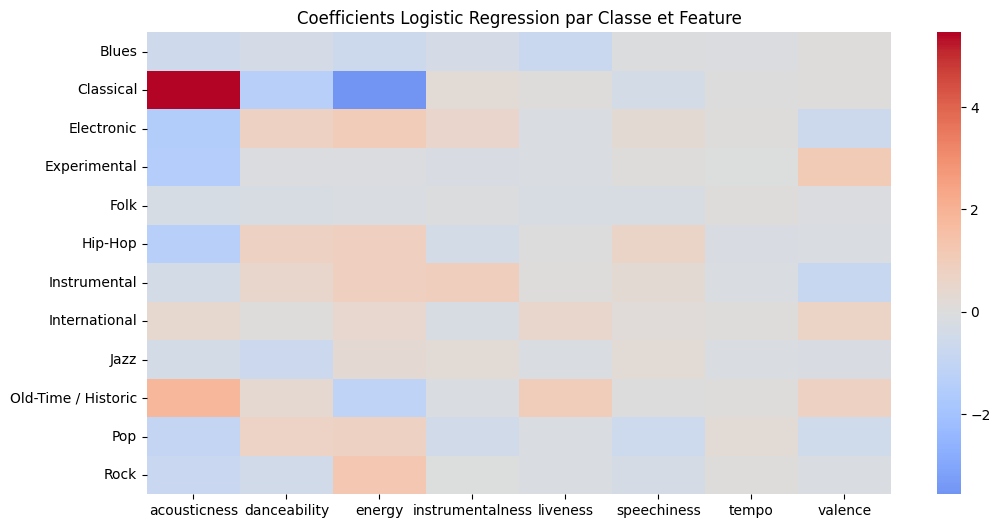

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap des coefficients
plt.figure(figsize=(12,6))
sns.heatmap(coef_df, cmap='coolwarm', center=0)
plt.title("Coefficients Logistic Regression par Classe et Feature")
plt.show()